In [32]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt
import os
from astropy.io import fits

os.getcwd()

'/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-04'

In [33]:
def DoubleBeta(x, beta, rc1, rc2, ratio, norm, const):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5)) + np.power(10,const)
    return out
def BetaModel(x, beta, rc, norm,const):
    out = norm * np.power(1. + (x / rc) ** 2, -3. * beta + 0.5) + const
    return out

In [ ]:
beta = 42.068108; rc1 = 10.888732/60; rc2 =  30.13499/60; ratio = 0.23852488; norm = 3.9734867e-05; const = 4.24e-07
x = np.logspace(-3, 1, 100)
y = DoubleBeta(x, beta, rc1, rc2, ratio, norm, const)

plt.plot(x,y)
plt.xscale('log')
plt.yscale('log')

In [ ]:
EPIC_exp_A223_nw_xmm_exp.fits

In [ ]:
datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302'
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {'0.5-7':[0.6, 1, 7, 0.23852488, -4, -6],
 "0.7-1.2":[0.6, 1, 7, 0.2, -5, -6]}
for ins in [ 'xmm']:#,'xmm','chandra'
    for band in ['0.5-7']:#, 
        for clus in ['A222',  'A223']:
            ra = radec_lst[clus][0]
            dec = radec_lst[clus][1]
            print(f'{ins}, {band}, {clus}, {ra}, {dec}')
            path = f'{datapath}/{ins}'
            if ins=='chandra':
                # reg = f'{path}/wavdetect_merge_clean_withexp_src_fk5.reg'
                img = f'{path}/images/{band}_band1_thresh.fits'
                # exp = f'{path}/images/0.5-7_band1_thresh_srcmsk_expmap.fits'
                exp = f'{path}/images/{band}_band1_thresh_srcmsk_{clus}filamsk_expmap_edgemsk.fits'
                bkg = f'{path}/images/{band}_band1_nxb_scaled.fits'
            elif ins=='xmm':
                # reg = f'{path}/EPIC_src_edit_man_fk5.reg'
                if band =='0.5-7':
                    img = f'{path}/{band}/EPIC_cts.fits'
                    # exp = f'{path}/{band}/EPIC_exp_srcmsk.fits'
                    exp = f'{path}/{band}/EPIC_exp_{clus}filamsk_srcmsk.fits'
                    bkg = f'{path}/{band}/EPIC_bkg.fits'
                elif band =='0.7-1.2':
                    img = f'{path}/{band}/EPIC_cts_700-1200.fits'
                    exp = f'{path}/{band}/EPIC_exp_700-1200_{clus}filamsk_srcmsk.fits'
                    bkg = f'{path}/{band}/EPIC_bkg_700-1200.fits'

            # # for nw region only
            # exp = f'{path}/0.5-7/EPIC_exp_A223_nw_xmm_exp.fits'
            dat=pyproffit.Data(imglink=img,explink=exp,bkglink=bkg)
            # fig = plt.figure(figsize=(6,6))
            # s1=plt.subplot(221)
            # plt.imshow(np.log10(dat.img),aspect='auto')
            # print(dat.img.max(), dat.img.min())
            # print(dat.bkg.max(), dat.bkg.min())
            # print((dat.img-dat.bkg).min(), (dat.img-dat.bkg).max())
            # s2=plt.subplot(222)
            # plt.imshow(dat.exposure,aspect='auto')
            
            prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=20., binsize=6, binning='log')
            prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)

            # ## Beta
            # mod=pyproffit.Model(pyproffit.BetaModel)
            # fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta=0.6, rc=1, norm=-2, bkg=-2, fitlow=0., fithigh=10.)

            ### Double Beta
            mod=pyproffit.Model(pyproffit.DoubleBeta)
            beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
            fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=20.)


            fitobj.Migrad()
            prof.Plot(model=mod)
            plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}')

            # # inspecting results
            # # fitobj.minuit.minos()
            # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
            os.makedirs(f'{datapath}/png', exist_ok=True)
            plt.savefig(f'{datapath}/png/A223_nw_{ins}_{clus}_{band}.pdf', dpi=300)
            # prof.Save(outfile=f"/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305/{clus}_{ins}_{band}_doublebeta_profile_inclfila.fits", model=mod)


mask expmap with filamsk

In [ ]:
from glob import glob
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302'
savepath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422'
os.chdir(savepath)
dats = glob(f'*exp*img')
f = open('msk_expmap.sh', 'w')
for dat in dats:
    for clus in ['A222', 'A223']:
        msk = f'{clus}filamsk_xmm.fits'
        f.write(f'farith ../{msk} {dat} {dat.split(".")[0]}_{clus}filamsk_expmap.fits "*" clobber=yes\n')
        msk = f'EPIC_src_edit_man_fk5_1e-6.fits'
        f.write(f'farith ../{msk} {dat.split(".")[0]}_{clus}filamsk_expmap.fits {dat.split(".")[0]}_srcmsk_{clus}filamsk_expmap.fits "*" clobber=yes\n')
f.close()
    


plot only emos

In [ ]:
datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422'
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -3, -4], "1200-2000":[0.6, 1, 7, 0.2, -3, -4], "2000-5000":[0.6, 1, 7, 0.2, -2, -4], "5000-7000":[0.6, 1, 7, 0.2, -2, -4]}
for ins in ['EMOS', 'EPIC']:#,'xmm','chandra'
    for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 
        for clus in ['A222',  'A223']:
            ra = radec_lst[clus][0]
            dec = radec_lst[clus][1]
            img = f'{ins}_cts_{band}.img'
            exp = f'{ins}_exp_{band}_srcmsk_{clus}filamsk_expmap.fits'
            bkg = f'{ins}_bkg_{band}.img'

            
            

            dat=pyproffit.Data(imglink=img, explink=exp, bkglink=bkg)
            prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=20., binsize=6, binning='log')
            prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)
            
            ### Double Beta
            mod=pyproffit.Model(pyproffit.DoubleBeta)
            beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
            fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=20.)
            
            fitobj.Migrad()
            prof.Plot(model=mod)
            plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}')

            # # inspecting results
            # # fitobj.minuit.minos()
            # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
            os.makedirs(f'{datapath}/png', exist_ok=True)
            plt.savefig(f'{datapath}/png/{ins}_{clus}_{band}.pdf', dpi=300)
            prof.Save(outfile=f"/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422/{clus}_{ins}_{band}_doublebeta_profile_inclfila.fits", model=mod)


plot obs and ins separately
1. mask the exp edge with 10arcmin circle centered on aimpoint
2. do the fitting and plot separately
3. merge
4. fit and plot the merged images


In [ ]:
from glob import glob
# workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422' # 230422
workpath = '/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-04'
os.makedirs(f'{workpath}/masks', exist_ok=True)
f = open(f'{workpath}/masks/make_masks.sh', 'w')
for obs in [101,201]:
    for ins in ['EMOS1', 'EMOS2', 'EPN']:
        files = glob(f'{workpath}/{ins}_exp_obs{obs}*.img')
        for file in files:
            f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_edgemsk.fits 'regfilter(\"{workpath}/masks/{ins}_obs{obs}_edgemsk.reg\",A.P1,A.P2) ? (1):(0)' a={file} clobber=yes\n")
            f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_srcmsk.fits 'regfilter(\"{workpath}/masks/EPIC_src_edit_man_fk5_1e-6.reg\",A.P1,A.P2) ? (0):(1)' a={file} clobber=yes\n")
            for clus in ['A222', 'A223']:
                f.write(f"ftimgcalc {workpath}/masks/{file.split('/')[-1]}_{clus}_filamsk.fits 'regfilter(\"{workpath}/masks/{clus}_filamsk_xmm.reg\",A.P1,A.P2) ? (0):(1)' a={file} clobber=yes\n")

f.close()

# sh make_masks.sh

In [ ]:
# mask edge, filamsk, sources from the exp maps
from glob import glob
os.chdir(workpath)
f = open(f'masks/mask_exps.sh', 'w')
f.write('#!/bin/bash\n')
for obs in [101,201]:
    for ins in ['EMOS1', 'EMOS2', 'EPN']:
        files = glob(f'{ins}_exp_obs{obs}*.img')
        for file in files:
            f.write(f"farith masks/{file.split('/')[-1]}_edgemsk.fits {file} {file.split('/')[-1].split('.')[0]}_edgemsk.fits '*' clobber=yes\n")
            f.write(f"farith {file.split('/')[-1].split('.')[0]}_edgemsk.fits masks/{file.split('/')[-1]}_srcmsk.fits {file.split('/')[-1].split('.')[0]}_edgemsk_srcmsk.fits '*' clobber=yes\n")
            for clus in ['A222', 'A223']:
                f.write(f"farith masks/{file.split('/')[-1]}_{clus}_filamsk.fits {file.split('/')[-1].split('.')[0]}_edgemsk_srcmsk.fits {file.split('/')[-1].split('.')[0]}_edgemsk_srcmsk_{clus}_filamsk.fits '*' clobber=yes\n")
f.close()

In [ ]:
# alter background file name

bkgfiles = glob('*scaled*.img')
for file in bkgfiles:
    if '-' in file:
        band = file.split('_')[-2]
        obs = file.split('_')[5]
        if 'mos1' in file:
            os.system(f'cp {file} EMOS1_bkg_{obs}_{band}.fits')
        elif 'mos2' in file:
            os.system(f'cp {file} EMOS2_bkg_{obs}_{band}.fits')
        elif 'pn' in file:
            band = file.split('_')[-3]
            obs = file.split('_')[5]
            os.system(f'cp {file} EPN_bkg_{obs}_{band}.fits')
        else:
            raise ValueError('wrong types!')


        

Corresponding pixels coordinates:  337.49073741299384 279.07162102846473
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 93.37                      │              Nfcn = 981              │
│ EDM = 0.0411 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬──

/Users/eusracenorth/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pyproffit/models.py:60: RuntimeWarning: invalid value encountered in multiply
  out = n2 * (comp1 + ratio * comp2) + c2


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.3                      │             Nfcn = 1164              │
│ EDM = 0.059 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

/Users/eusracenorth/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pyproffit/models.py:58: RuntimeWarning: overflow encountered in power
  n2 = np.power(10., norm)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 105.9                      │             Nfcn = 1134              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

/Users/eusracenorth/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pyproffit/models.py:60: RuntimeWarning: overflow encountered in multiply
  out = n2 * (comp1 + ratio * comp2) + c2


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 351.9                      │              Nfcn = 403              │
│ EDM = 1.09e+05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

<Figure size 640x480 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

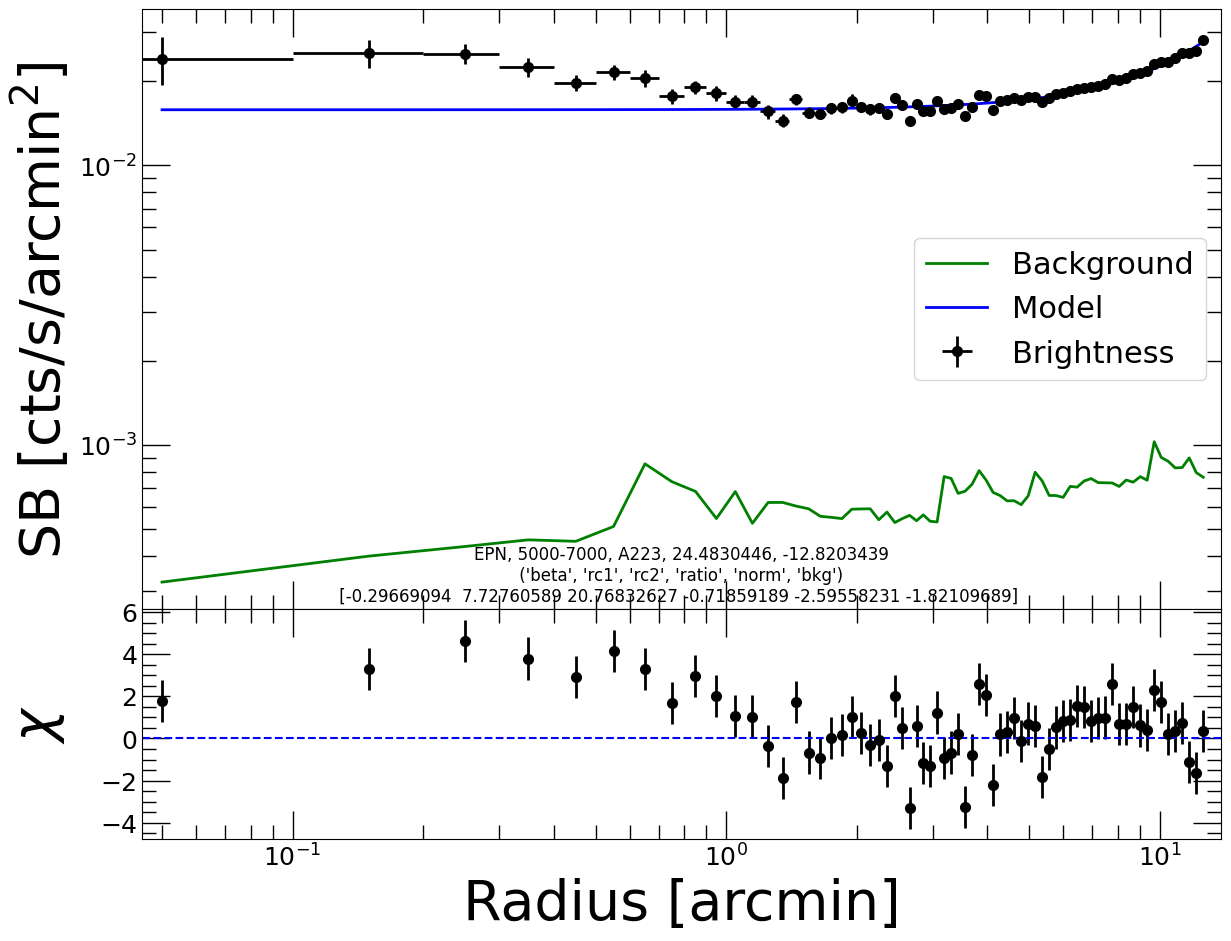

In [39]:
import datetime
# datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230422'
maxrad = 20.
datapath = '/Users/eusracenorth/Documents/suzaku_A222-223/xmm_data/merged/2023-05-04'
os.chdir(datapath)
radec_lst = {'A222':[24.3941937, -12.9933436], "A223":[24.4830446, -12.8203439]}
doublebeta_para = {"700-1200":[0.6, 1, 7, 0.2, -2, -4], "1200-2000":[0.6, 1, 7, 0.2, -1, -4], "2000-5000":[0.6, 1, 7, 0.2, -2, -4], "5000-7000":[0.6, 1, 7, 0.2, -2, -4]}
for ins in ['EMOS1', 'EMOS2', 'EPN']:#,'xmm','chandra'
    for obs in ['101', '201']:
        for band in ['700-1200', '1200-2000', '2000-5000', '5000-7000']:#, 
            for clus in ['A222',  'A223']:
                ra = radec_lst[clus][0]
                dec = radec_lst[clus][1]
                # img = f'{ins}_counts_obs{obs}_{band}.img'
                # exp = f'{ins}_exp_obs{obs}_edgemsk_srcmsk_{clus}_filamsk.fits'
                # bkg = f'{ins}_bkg_obs{obs}_{band}.fits'
                img = f'{ins}_counts_obs{obs}_{band}_2023-05-04.img'
                exp = f'{ins}_exp_obs{obs}_{band}_2023-05-04_edgemsk_srcmsk_{clus}_filamsk.fits'
                bkg = glob(f'{ins}_obs{obs}_bkg_clean_2023-05-04_{band}_scaled*.img')[0]

                dat=pyproffit.Data(imglink=img, explink=exp, bkglink=bkg)
                prof=pyproffit.Profile(dat, center_choice='custom_fk5', center_ra = ra, center_dec =dec, maxrad=maxrad, binsize=6, binning='log')
                prof.SBprofile(ellipse_ratio=1)#, angle_low=80, angle_high=140)
                
                ### Double Beta
                mod=pyproffit.Model(pyproffit.DoubleBeta)
                beta, rc1,rc2, ratio, norm, bkg = doublebeta_para[band]
                fitobj=pyproffit.Fitter(model=mod, method='cstat', profile=prof, beta = beta, rc1 = rc1, rc2 =  rc2, ratio = ratio, norm = norm, bkg=bkg, fitlow=0.1, fithigh=maxrad)
                
                fitobj.Migrad()
                prof.Plot(model=mod)
                plt.title(f'{ins}, {band}, {clus}, {ra}, {dec}\n {mod.parnames} \n {mod.params}  ')

                # # inspecting results
                # # fitobj.minuit.minos()
                # #fitobj.minuit.draw_mncontour('beta', 'rc', cl=(0.68, 0.9, 0.99))
                os.makedirs(f'{datapath}/png/{int(maxrad)}am/{datetime.date.today()}', exist_ok=True)
                os.makedirs(f'{datapath}/profiles/{int(maxrad)}am/{datetime.date.today()}', exist_ok=True)
                plt.savefig(f'{datapath}/png/{int(maxrad)}am/{datetime.date.today()}/{ins}_{clus}_{band}_{obs}.png')
                prof.Save(outfile=f"{datapath}/profiles/{int(maxrad)}am/{datetime.date.today()}/{clus}_{ins}_{band}_obs{obs}_doublebeta_profile.fits", model=mod)

                

In [ ]:
print(mod.params)

In [ ]:
def basic_figure_style():
    SMALL_SIZE = 5*4                                       
    MEDIUM_SIZE = 8*2
    BIGGER_SIZE = 10*4

    plt.rc('font', size=MEDIUM_SIZE, family='serif')          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)                     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE, direction='out')    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)                    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
    plt.rc('lines', linewidth=3) 
    plt.rc('axes', grid=True) #
    plt.rc('grid', alpha=0.7) #
    plt.rc('xtick', top=True)
    plt.rc('ytick', right=True)
    plt.rc('axes.formatter', use_mathtext=True, min_exponent=4, useoffset=False)
    plt.rc('figure', figsize='6, 6')                         # size of the figure, used to be '4, 3' in inches
    ######################################################
basic_figure_style()


In [ ]:
from glob import glob
cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
path = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305'
xmmfiles = glob(f'{path}/*chan*0.7-1.2*doublebeta*10am*')
xmmfiles = np.sort(xmmfiles)
print(xmmfiles)
fig, axs = plt.subplots(2, len(xmmfiles), sharex=True, figsize=(len(xmmfiles)*10,8),gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0,wspace=0.2)
fig.align_ylabels()
for i, fname in enumerate(xmmfiles):
    hdul = fits.open(fname)
    dat = hdul[1].data 
    mdl = hdul[2].data
    model = DoubleBeta(dat['RADIUS'], mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4],  mdl['VALUE'][5])
    axs[0,i].errorbar(dat['RADIUS'], dat['SB'], yerr=dat['ERR_SB'], xerr=dat['WIDTH'], c = 'k', label = 'data', alpha=0.8,fmt = 'o')
    axs[0,i].plot(dat['RADIUS'], model, label = 'model', c = 'b')
    axs[0,i].plot(dat['RADIUS'], dat['BKG'], label = 'bkg', c = 'g')
    
    chi = (dat['SB'] - model) / dat['ERR_SB']
    axs[1,i].errorbar(dat['RADIUS'], chi, yerr=np.ones(len(dat['RADIUS'])),  c = 'k', label = 'data', alpha=0.8, fmt='o')
    axs[1,i].axhline(0, c='b', linestyle = '--')

    # axs[0,i].set_title(f'{fname.split("/")[-1]}')
    axs[0,i].set_yscale('log')
    # axs[0,i].set_ylim(1e-7,0.01)
    axs[1,i].set_yscale('linear')

for i in range(2):
    for j in range(len(xmmfiles)):
        axs[i,j].minorticks_on()
        axs[i,j].tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
        axs[i,j].tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
        axs[i,j].set_xlabel('Radius [arcmin]')
        axs[0,j].set_ylabel('SB [$\\rm cts/s/cm^2/arcmin^2$]')
        axs[1,j].set_ylabel('$\chi$')
axs[0,1].legend(frameon=False)
plt.xscale('log')
plt.yscale('linear')

# plt.savefig(f'{path}/pdf/{fnasplit("/")[-1].split(".fits")[0]}_A222left_A223right_sbprofile.pdf', dpi=300)
# print(f'{fname.split("/")[-1].splime.t(".fits")[0]}_A222left_A223right_sbprofile.pdf has been saved!')


make https://arxiv.org/pdf/2110.06224.pdf like plot

In [ ]:
from glob import glob
path = '/Users/eusracenorth/Documents/suzaku_A222-223/profile_230302/results_230305'
cb = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
chandra_Aeff = 420


def DoubleBeta_wobkg(x, beta, rc1, rc2, ratio, norm):
    out = np.power(10,norm) * (np.power(1 + (x / rc1) **2, -3 * beta + 0.5) + ratio * np.power(1 + (x / rc2) **2, -3 * beta + 0.5))
    return out
fig, ax = plt.subplots(figsize = (16,8))
fname = glob(f'{path}/*A222*chan*0.7-1.2*doublebeta*10am*')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data

# plt.errorbar(dat['RADIUS'], dat['SB']-np.power(10,mdl['VALUE'][5]), yerr=dat['ERR_SB'], xerr=dat['WIDTH'], c = cb[-2], alpha=0.5,fmt = 'o')

a222mdl = DoubleBeta_wobkg(np.arange(0,7.5,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a222mdl = np.concatenate((a222mdl[::-1], a222mdl))
x_a222mdl = (-7.5,7.5)
fname = glob(f'{path}/*A223*chan*0.7-1.2*doublebeta*10am*')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
# plt.errorbar(6 - dat['RADIUS'], dat['SB']-np.power(10,mdl['VALUE'][5]), yerr=dat['ERR_SB'], xerr=dat['WIDTH'], label = 'Chandra', c = cb[-2],alpha=0.5,fmt = 'o')

a223mdl = DoubleBeta_wobkg(np.arange(0,7.5,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a223mdl = np.concatenate((a223mdl[::-1], a223mdl))
x_a223mdl = (11.5-7.5,11.5+7.5)

x_mdl = np.arange(-7.5,11.5+7.5+0.01,0.01)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>x_a222mdl[0])&(x_mdl<=x_a222mdl[1])] = y_a222mdl
plt.plot(x_mdl, y_mdl* chandra_Aeff,c = 'r', alpha = 0.5)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<x_a223mdl[1])] = y_a223mdl
plt.plot(x_mdl, y_mdl* chandra_Aeff,c = 'r', alpha = 0.5)
plt.text(10.5,3e-4, 'A223')
plt.text(-1,3e-4, 'A222')
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>x_a222mdl[0])&(x_mdl<=x_a222mdl[1])] = y_a222mdl
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<x_a223mdl[1])] += y_a223mdl
plt.plot(x_mdl, y_mdl* chandra_Aeff, alpha = 0.5,linestyle = '--', label = 'chandra sum mdl')

## load xmm data
# xmm_skybg = np.array([0.0033413481427292846, 0.002563827590320338])
# skybg = xmm_skybg.min()#/3.08
skybg = (1.77e-3+2*5.485e-4)/5*3/3.08
plt.axhline(skybg)
xmm_Aeff = 1 #400
fname = glob(f'{path}/*A222*xmm*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
a222mdl = DoubleBeta_wobkg(np.arange(0,7.5,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a222mdl = np.concatenate((a222mdl[::-1], a222mdl))/xmm_Aeff
x_a222mdl = np.arange(-7.5,7.5, 0.01)
plt.plot(x_a222mdl, y_a222mdl)
msk = dat['RADIUS'] < 6
plt.errorbar(dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-5],alpha=0.5,fmt = 'o')

# plt.axhline(skybg/xmm_Aeff, label = '0', c = cb[0])
fname = glob(f'{path}/*A222*xmm*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-3],alpha=0.5,fmt = 'o')
xmm_Aeff = 1 #400
fname = glob(f'{path}/*A223*xmm*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
a223mdl = DoubleBeta_wobkg(np.arange(0,7.5,0.01), mdl['VALUE'][0], mdl['VALUE'][1], mdl['VALUE'][2],  mdl['VALUE'][3],  mdl['VALUE'][4])
y_a223mdl = np.concatenate((a223mdl[::-1], a223mdl))/xmm_Aeff
x_a223mdl = np.arange(11.5-7.5,11.5+7.5, 0.01)
plt.plot(x_a223mdl, y_a223mdl)
y_mdl = np.zeros(x_mdl.shape)
y_mdl[(x_mdl>(x_a222mdl[0]-0.01))&(x_mdl<=x_a222mdl[-1])] = y_a222mdl
y_mdl[(x_mdl>=x_a223mdl[0])&(x_mdl<(x_a223mdl[-1]+0.01))] += y_a223mdl
plt.plot(x_mdl, y_mdl, alpha = 0.5,linestyle = '--', label = 'xmm sum mdl')
msk = dat['RADIUS'] < 6

plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-5],alpha=0.5,fmt = 'o', label = 'xmm_wofila')

# plt.axhline(skybg/xmm_Aeff, label = '1', c = cb[1])
fname = glob(f'{path}/*A223*xmm*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'][msk]-skybg)/xmm_Aeff, yerr=dat['ERR_SB'][msk]/xmm_Aeff, xerr=dat['WIDTH'][msk], c = cb[-3],label = 'XMM',alpha=0.5,fmt = 'o')

# load chandra data
# chan_skybg = np.array([1.563939922864141e-06, 1.7019209655102093e-06])
# skybg = chan_skybg.min()#/3.08 ##3.08 for0.7-1.2 keV

skybg = 2.723e-4/5*3/3.08
plt.axhline(skybg)
fname = glob(f'{path}/*A222*chandra*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-2],alpha=0.5,fmt = 'o')

fname = glob(f'{path}/*A222*chandra*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
# plt.errorbar(dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-4],alpha=0.5,fmt = 'o')

fname = glob(f'{path}/*A223*chandra*0.7-1.2*doublebeta_profile.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-2],label = 'chandra_wofila',alpha=0.5,fmt = 'o')

fname = glob(f'{path}/*A223*chandra*0.7-1.2*doublebeta_profile_inclfila.fits')[0]
hdul = fits.open(fname)
dat = hdul[1].data 
mdl = hdul[2].data
msk = dat['RADIUS'] < 6
# plt.errorbar(11.5-dat['RADIUS'][msk], (dat['SB'])[msk]* chandra_Aeff-skybg, yerr=dat['ERR_SB'][msk]* chandra_Aeff, xerr=dat['WIDTH'][msk], c = cb[-4],label = 'chandra',alpha=0.5,fmt = 'o')

plt.axvline(4, c= cb[-1])
plt.axvline(4+3.5, c = cb[-1], label = 'filabox')
plt.yscale('log')
plt.ylabel('$\\rm S_x\ (cts\ s^{-1}\ arcmin^{-2}$)')
plt.xlabel('Radius(arcmin)')
plt.legend()
plt.xticks(np.arange(-7.5, 11.5+7.5,1.5))
plt.title('0.7-1.2 keV')


In [ ]:
plt.text?